In [1]:
# set root dir in system path
import sys
sys.path.insert(0, '/Users/dish/Code/codeQual')
print(sys.path)
from codeQual import set_device
device = set_device.set()

['/Users/dish/Code/codeQual', '/Users/dish/anaconda3/envs/codequal/lib/python310.zip', '/Users/dish/anaconda3/envs/codequal/lib/python3.10', '/Users/dish/anaconda3/envs/codequal/lib/python3.10/lib-dynload', '', '/Users/dish/anaconda3/envs/codequal/lib/python3.10/site-packages']


In [2]:
MODEL_NAME = 'microsoft/codebert-base'
DATESET = '../data/hf_code_qual_dataset_v1'

In [3]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
model_name = MODEL_NAME
num_classes = 3
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_classes, max_length=512).to(device)
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
tokenizer.add_special_tokens({"pad_token": "[PAD]"})
print(model.config)

/Users/dish/anaconda3/envs/codequal/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaConfig {
  "_name_or_path": "microsoft/codebert-base",
  "architectures": [
    "RobertaModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_length": 512,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.39.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}



In [4]:
from transformers import AutoTokenizer
from datasets import Dataset, DatasetDict, load_dataset
code_qual_dataset = DatasetDict.load_from_disk(DATESET)

def tokenize(batch):
    return tokenizer(batch["submission"], padding=True, truncation=True)


codebert_encoded: DatasetDict = code_qual_dataset.map(tokenize, batched=True, batch_size=None)
codebert_encoded

DatasetDict({
    train: Dataset({
        features: ['problem_id', 'problem', 'submission_id', 'submission', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1650
    })
    validation: Dataset({
        features: ['problem_id', 'problem', 'submission_id', 'submission', 'label', 'input_ids', 'attention_mask'],
        num_rows: 300
    })
    test: Dataset({
        features: ['problem_id', 'problem', 'submission_id', 'submission', 'label', 'input_ids', 'attention_mask'],
        num_rows: 300
    })
})

In [5]:
from torch.nn.functional import cross_entropy
import torch

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [6]:
# Convert our dataset back to PyTorch tensors

codebert_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
codebert_encoded["test"] = codebert_encoded["test"].map(forward_pass_with_label, batched=True, batch_size=4)
codebert_encoded["validation"] = codebert_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=4)
codebert_encoded

Map: 100%|██████████| 300/300 [00:05<00:00, 50.29 examples/s]


DatasetDict({
    train: Dataset({
        features: ['problem_id', 'problem', 'submission_id', 'submission', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1650
    })
    validation: Dataset({
        features: ['problem_id', 'problem', 'submission_id', 'submission', 'label', 'input_ids', 'attention_mask', 'loss', 'predicted_label'],
        num_rows: 300
    })
    test: Dataset({
        features: ['problem_id', 'problem', 'submission_id', 'submission', 'label', 'input_ids', 'attention_mask', 'loss', 'predicted_label'],
        num_rows: 300
    })
})

In [7]:
codebert_encoded.set_format("pandas")
cols = ["problem", "submission", "label", "predicted_label", "loss"]
df_test = codebert_encoded["test"][:][cols]
df_val = codebert_encoded["validation"][:][cols]
df_test

,problem,submission,label,predicted_label,loss
0,An integer N is a multiple of 9 if and only if...,target = input()\nsum = 0\nfor each in target:...,2,2,0.931539
1,Snuke is having a barbeque party.\nAt the part...,import sys\ninput=sys.stdin.readline\n\nN = in...,2,2,0.900610
2,Write a program which prints $n$-th fibonacci ...,n = int(input())\nl = [0 for _ in range(10**4)...,2,2,0.877398
3,Takahashi is meeting up with Aoki.\nThey have ...,"D, T, S = map(int, input().split())\n\nif (D /...",2,2,0.926061
4,You can obtain profits from foreign exchange m...,s_max = -float('inf')\ns = 0\nfor i in range(i...,2,2,0.880470
...,...,...,...,...,...
295,There are N positive integers written on a bla...,n=int(input())\na=[int(i)for i in input().spli...,0,2,1.439208
296,Given are two strings S and T.\nLet us change ...,S = list(str(input()))\nT = list(str(input()))...,0,2,1.442036
297,"In some other world, today is Christmas.\nMr. ...","N, X = map(int, input().split())\ndim, ans = [...",0,2,1.440685
298,There are N integers written on a blackboard. ...,"n = int(input())\nA = list(map(int,input().spl...",0,2,1.450968


In [8]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def evaluate(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    return accuracy, f1, precision, recall

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [10]:
import numpy as np

Y_test = np.array(df_test["label"])
Y_test_preds = np.array(df_test["predicted_label"])

Y_val = np.array(df_val["label"])
Y_val_preds = np.array(df_val["predicted_label"])

Y_test.shape, Y_test_preds.shape

((300,), (300,))

In [11]:
print("Test scores:")
print(evaluate(Y_test, Y_test_preds))
print("Validation scores:")
print(evaluate(Y_val, Y_val_preds))

Test scores:
(0.3333333333333333, 0.16666666666666666, 0.11111111111111109, 0.3333333333333333)
Validation scores:
(0.3333333333333333, 0.16666666666666666, 0.11111111111111109, 0.3333333333333333)


/Users/dish/anaconda3/envs/codequal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dish/anaconda3/envs/codequal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


['low', 'average', 'high']


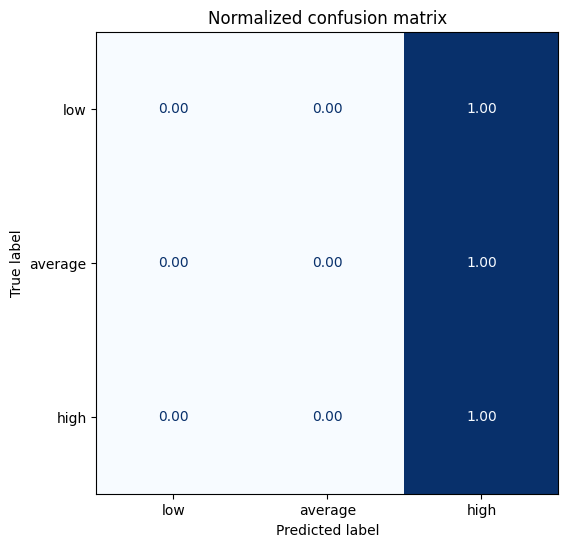

In [12]:
labels = code_qual_dataset['train'].features["label"].names
print(labels)
plot_confusion_matrix(Y_test_preds, Y_test, labels)

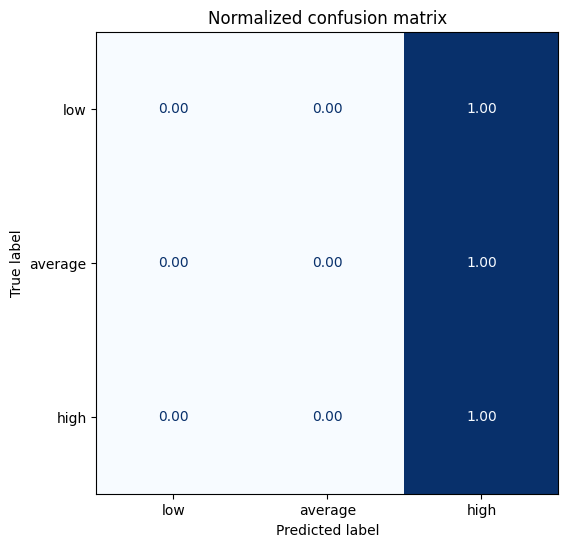

In [13]:
plot_confusion_matrix(Y_val_preds, Y_val, labels)